In [2]:
from book_cover.ml_logic.data import get_data
from book_cover.ml_logic.preprocessor import preprocess_images

In [3]:
import numpy as np

import matplotlib.pyplot as plt

# Keras imports
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
train_x = get_data("../raw_data/train_x.csv")
labels_train = get_data("../raw_data/train_y.csv")
images_train = preprocess_images(train_x, (100, 100))

In [29]:
test_x = get_data("../raw_data/test_x.csv")
labels_test = get_data("../raw_data/test_y.csv")
images_test = preprocess_images(test_x, (100, 100))

In [30]:
images_train.shape, images_test.shape

((51300, 100, 100, 3), (5700, 100, 100, 3))

In [31]:
# Considering only 1/10th of the 50K+ images
reduction_factor = 10

# Choosing the random indices of small train set and small test set
idx_train =  np.random.choice(len(images_train), round(len(images_train)/reduction_factor), replace=False)
idx_test =  np.random.choice(len(images_test), round(len(images_test)/reduction_factor), replace=False)

# Collecting the two subsamples images_train_small and images_test_small from images_train and images_test
images_train_small = images_train[idx_train]
images_test_small = images_test[idx_test]

# and their corresponding labels
labels_train_small = labels_train['Genre_id'][idx_train]
labels_test_small = labels_test['Genre_id'][idx_test]

images_train_small.shape, images_test_small.shape

((5130, 100, 100, 3), (570, 100, 100, 3))

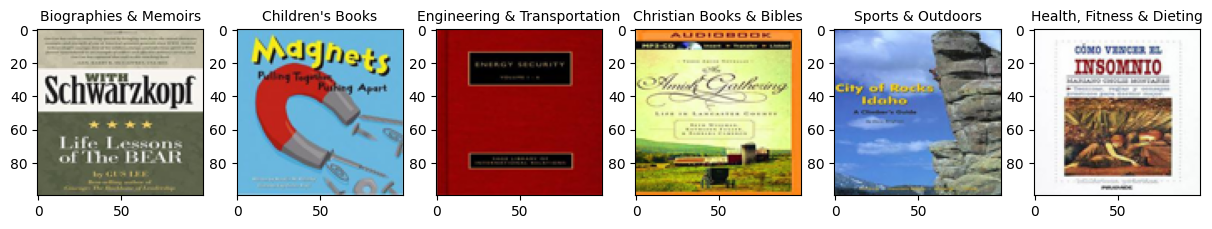

In [32]:
# Let's plot few images to see what they look like
plt.figure(figsize=(15,5))
for i in range(6):
    plt.subplot(1,6, i+1)
    img = images_train[i]
    label = labels_train['Genre_name'][i]
    plt.imshow(img)
    plt.title(label, fontsize=10)

# Image preprocessing

In [34]:
# Normalizing pixels' intensities
X_train = images_train / 255.
X_train_small = images_train_small / 255.
X_test = images_test / 255.
X_test_small = images_test_small / 255.

In [42]:
# Encoding the labels
y_train = to_categorical(labels_train['Genre_id'])
y_train_small = to_categorical(labels_train_small)
y_test = to_categorical(labels_test['Genre_id'])
y_test_small = to_categorical(labels_test_small)

# CNN on the small training set

In [49]:
def initialize_model():
    model = models.Sequential()
    
    # Convolution 1 & MaxPooling
    model.add(layers.Conv2D(8, (4,4), input_shape=(100, 100, 3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    # Convolution 2 & MaxPooling
    model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    # Convolution 3 & MaxPooling
    model.add(layers.Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    # Convolution 4 & MaxPooling
    model.add(layers.Conv2D(64, (2,2), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    # Flattening
    model.add(layers.Flatten())
    
    # Hidden Dense layer
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    
    ### Last layer - Classification Layer with 30 outputs corresponding to 30 digits
    model.add(layers.Dense(30, activation='softmax'))
    
    return model

In [50]:
def compile_model(model):
    '''return a compiled model suited for the CIFAR-10 task'''

    ### Model compilation
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

In [51]:
# Fitting the CNN on the small training set

es = EarlyStopping(patience = 5, restore_best_weights=True)

model = compile_model(initialize_model())

# Fit the model on the train data
history = model.fit(
    X_train_small,
    y_train_small,
    validation_split = 0.3,
    epochs = 50,
    batch_size = 32, 
    verbose = 0, 
    callbacks = [es]
)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

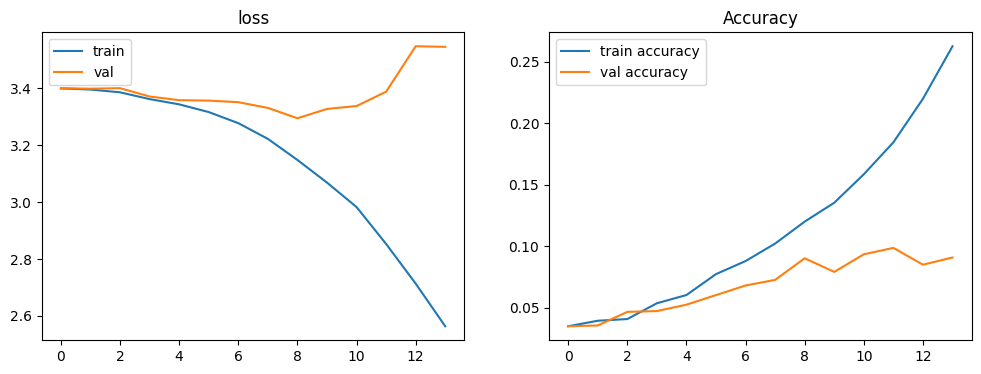

In [53]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history)

In [54]:
# Evaluating the CNN
loss, accuracy = model.evaluate(X_test_small, y_test_small, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 8.60%


# Increasing the size of the training data

In [55]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

model = compile_model(initialize_model())

# Fit the model on the train data
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.3,
    epochs = 50,
    batch_size = 32, 
    verbose = 0, 
    callbacks = [es]
)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 12.58%


(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

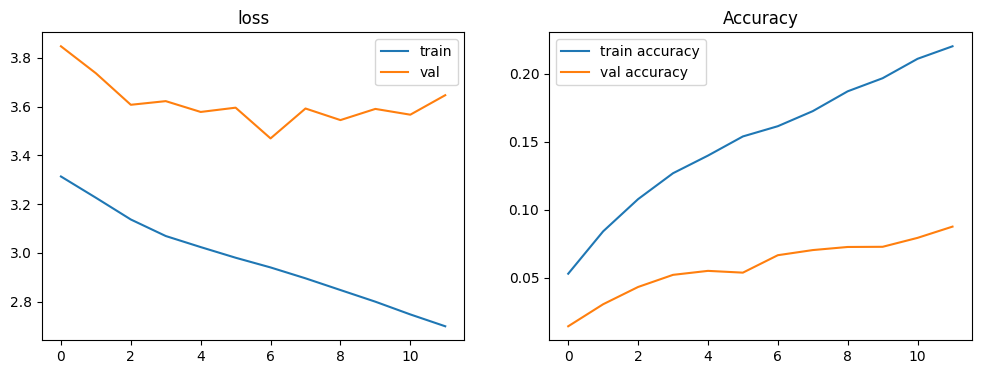

In [56]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history)